## Symbolic regression: finding the number of Drude and Lorentz terms from an spectrum of dielectric constant
---

This part objective is to obtain the number of Drude and Lorentz terms from the dielectric constant spectrum.

The dielectric constant functional form is $$\epsilon(\omega)=\epsilon_r-\sum_j\frac{\omega_{P_j}^2}{\omega(\omega+i\gamma_j)}-\sum_j\frac{\Delta\epsilon_j\Omega_j^2}{\omega^2-\Omega_j^2+i\omega\Gamma_j},$$

where the first sum is named after Drude and the second one after Lorentz.

Given an spectra that follows this functional form results very hard to determine the number of terms of each kind. In this code we try to build a way to obtain these numbers via the neural networks' tools.

# Plotting functions

In [ ]:
def plot_score(pathresults,history_keras,epoch_ini = 0,n = 0):
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    ['loss', 'accuracy', 'val_loss', 'val_accuracy']
    history_dict=history_keras.history
    training_cost=history_dict['loss']
    training_accuracy=history_dict['accuracy']
    evaluation_cost=history_dict['val_loss']
    evaluation_accuracy=history_dict['val_accuracy']

    epochs=len(evaluation_cost)
    xx = np.linspace(epoch_ini,epochs-1,epochs-epoch_ini)
    # in a file
    filemse="/loss_mse_.dat"
    file=os.path.exists(pathresults+filemse)
    if (file):
        os.remove(pathresults+filemse)
        print(pathresults+filemse+" removed")
    with open(pathresults+filemse, 'w') as f1:
       for i in range(epoch_ini,epochs):
           summary= str(xx[i-epoch_ini])+' '+str(evaluation_cost[i])+' '+str(evaluation_accuracy[i])+' '+str(training_cost[i])+' '+str(training_accuracy[i])+''+'\n'
           f1.write(summary)
    f1.close()

    # as a figure
    # Four axis
    fig2, ax2 = plt.subplots(2,2, figsize=(10,10)) #sharex='col', sharey='row',
    ax2[0,0].plot(xx,evaluation_cost[epoch_ini:], color="red", label="evaluation cost")
    ax2[0,1].plot(xx,evaluation_accuracy[epoch_ini:], color="blue", label="evaluation accuracy")
    ax2[1,0].plot(xx,training_cost[epoch_ini:], color="orange", label="validation cost")
    ax2[1,1].plot(xx,training_accuracy[epoch_ini:], color="cyan", label="validation accuracy")
    txt = "$epoch$"
    ax2[0,0].set_xlabel(txt)
    ax2[0,0].legend()
    ax2[0,1].set_xlabel(txt)
    ax2[0,1].legend()
    ax2[1,0].set_xlabel(txt)
    ax2[1,0].legend()
    ax2[1,1].set_xlabel(txt)
    ax2[1,1].legend()
    fig2.savefig(pathresults+"/epochs_evolution.png", dpi=200, facecolor="#f1f1f1")
    plt.savefig(f"{'./'}/Red_neuronal{n}.png", dpi=200)

def GraphData(datalist, typeplotlist, labellist, linewidthlist,Title, filename_data,\
              Axx = "x", Axy = "y",\
              left=None, right=None, bottom=None, top = None):
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(4, 3))
    plt.rcParams['font.size'] = 8.
    ngraph = len(datalist)
    markers=['o','v','s',"."]
    marker_size=[5,4,3,2]
    for il in range(ngraph):
        print(labellist[il])
        plt.plot(datalist[il][0],
                 datalist[il][1],
                 typeplotlist[il],
                 label=labellist[il],
                 marker=markers[il],markersize=marker_size[il],
                 linewidth=linewidthlist[il])
    plt.axis([left, right, bottom, top])
    if ngraph != 1:
        plt.legend(loc='best')
    plt.xlabel(Axx,fontsize=30)
    plt.ylabel(Axy,fontsize=30)
    plt.title(Title, fontsize=12)
    plt.savefig(filename_data, bbox_inches='tight')
    plt.grid()
    plt.show()

# Main imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)
# Tensorflow Keras packages
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers,Model
from sympy.utilities.lambdify import lambdify
import sympy as sym
from keras.utils import to_categorical
#from keras.utils.np_utils import to_categorical

2.14.0


In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/ImagenesTFM'

Mounted at /content/gdrive


# Definition of the Drude-Lorent dielectric constant function

In [ ]:
def func_target(wh,D,L,eps0,wplasma,gamma,Omega,Gamma,deps):
    '''
    Builds dielectric constant's real and imaginary parts
    wh: frequency
    D, L: number of each kind's terms
    eps0,wplasma,gamma,Omega,Gamma,deps: lists of the dielectric constant's parameters
    '''
    er = eps0
    ei = 0
    for d in range(D):
        er -= wplasma[d]**2/(wh**2 + gamma[d]**2)
        ei += (gamma[d]/wh)*(wplasma[d]**2/(wh**2 + gamma[d]**2))
    for l in range(L):
        er -= (deps[l]*Omega[l]**2)/((wh**2 - Omega[l]**2)**2+(Gamma[l]*wh)**2)*(wh**2 - Omega[l]**2)
        ei += ((deps[l]*Omega[l]**2)/((wh**2 - Omega[l]**2)**2+(Gamma[l]*wh)**2))*(Gamma[l]*wh)
    return er,ei

# Ajuste sobre constante dieléctrica con una capa de red neuronal

###Notes about the different *layer* functions defined in this test:


*   All use the same mechanism, based in the Keras' class *Layer*.
*   There's a FuncLayer for the Drude terms, another for Lorentz terms and another one for the constant $\varepsilon_0$. These are defined so that dielectric constant parameters coincide with each layers' parameters.
*   If there are D Drude terms and L Lorentz terms, they can be defined separately and added up later with Keras function *tf.keras.layers.Add()*.
*   The fourth function defined, *FuncLayer_DrudeLorentz*, is used to check if exists a difference between defining each term separately and adding them up later or defining all terms in the same single *layer* function.



In [ ]:
class FuncLayer_eps0(tf.keras.layers.Layer):
    def __init__(self, num_outputs,initial_value,
                 **kwargs):
        super(FuncLayer_eps0, self).__init__(**kwargs)
        self.num_outputs = num_outputs
        self.initial_value = initial_value
    def build(self, input_shape):
        self.eps0 = self.add_weight(name='eps0',
                                      shape=[1, self.num_outputs],
                                       initializer=tf.keras.initializers.Constant(value=self.initial_value),
                                      trainable=True,
                                       constraint=tf.keras.constraints.NonNeg())

    def call(self,inputs):
        print(self.eps0.shape)
        output = self.eps0 + 0*inputs
        return output

class FuncLayer_Drude(tf.keras.layers.Layer):
    def __init__(self, num_outputs, initial_values,
                 **kwargs):
        super(FuncLayer_Drude, self).__init__(**kwargs)
        self.num_outputs = num_outputs
        self.initial_values = initial_values
    def build(self, input_shape):
        self.wplasma = self.add_weight(name='wplasma',
                                      shape=[input_shape[-1], self.num_outputs],
                                       initializer=tf.keras.initializers.Constant(value=self.initial_values[0]),
                                      trainable=True,
                                       constraint=tf.keras.constraints.NonNeg())
        self.gamma = self.add_weight(name='gamma',
                                   shape=[1,self.num_outputs],
                                    initializer=tf.keras.initializers.Constant(value=self.initial_values[1]),
                                   trainable=True,
                                    constraint=tf.keras.constraints.NonNeg())

    def call(self, inputs, function):
        print(inputs.shape,self.wplasma.shape)
        output = function(inputs, self.wplasma, self.gamma)
        return output


class FuncLayer_Lorentz(tf.keras.layers.Layer):
    def __init__(self, num_outputs,initial_values,
                 **kwargs):
        super(FuncLayer_Lorentz, self).__init__(**kwargs)
        self.num_outputs = num_outputs
        self.initial_values = initial_values
    def build(self, input_shape):
        self.Omega = self.add_weight(name='Omega',
                                   shape=[1,self.num_outputs],
                                   initializer=tf.keras.initializers.Constant(value=self.initial_values[1]),
                                   trainable=True,
                                   constraint=tf.keras.constraints.NonNeg())
        self.Gamma = self.add_weight(name='Gamma',
                                      shape=[input_shape[-1], self.num_outputs],
                                      initializer=tf.keras.initializers.Constant(value=self.initial_values[0]),
                                      trainable=True,
                                      constraint=tf.keras.constraints.NonNeg())
        self.deps = self.add_weight(name='deps',
                                      shape=[input_shape[-1], self.num_outputs],
                                      initializer=tf.keras.initializers.Constant(value=self.initial_values[2]),
                                      trainable=True,
                                      constraint=tf.keras.constraints.NonNeg())

    def call(self, inputs, function):
        output = function(inputs, self.Gamma, self.Omega, self.deps)
        return output

In [ ]:

'''
#Datos Au
eps0 = 5.967

wplasma = [8.792]
gamma = [0.065]

Gamma = [0.433]
Omega = [2.684]
deps = [1.09]
'''
#'''
#Datos Cu
eps0 = 1

wplasma = [8.212]
gamma = [0.03]

Gamma = [0.378, 1.056, 3.213, 4.305]
Omega = [0.291, 2.957, 5.3, 11.18]
deps = [84.49, 1.395, 3.018, 0.598]
#'''

D = 1; L = 4

#Define wh range
n_sample = 200
wh0=1.24;whf=3.1
whdata = np.linspace(wh0,whf,n_sample)
erdata,eidata = func_target(whdata,D,L,eps0,wplasma,gamma,Omega,Gamma,deps)

#shuffle the data
shuffle_list = np.random.permutation(range(n_sample))
print(shuffle_list)
whdata = whdata[shuffle_list]
erdata = erdata[shuffle_list]
eidata = eidata[shuffle_list]
#erdata = (erdata - np.mean(erdata))/np.std(erdata)
#eidata = (eidata - np.mean(eidata))/np.std(eidata)
#e_std = np.sqrt(np.std(erdata)**2+np.std(eidata)**2)
#erdata = (erdata)/e_std
#eidata = (eidata)/e_std
#print(max(erdata),max(eidata))


#Check data and labels previously defined
'''print(wh_train.shape[0],'train samples')
print(wh_val.shape[0],'test samples')
print("wh_train shape",wh_train.shape)
print("er & ei shapes",er_train.shape,ei_train.shape)'''

# Input and output neurons (from the data)
input_neurons  = 1
output_neurons = 1

# Hiperparameters
batch_size = 32
epochs = 50

delta=np.random.rand()
print(delta)

# Using sympy to define functions

wh_sym = sym.symbols("wh")
wplasma_sym = [sym.symbols(f"wp{d}") for d in range(D)]
gamma_sym = [sym.symbols(f"g{d}") for d in range(D)]

funcsDrude_list_r=[-wplasma_sym[d]**2/(wh_sym**2+gamma_sym[d]**2) for d in range(D)]
funcsDrude_list_i=[(gamma_sym[d]/wh_sym)*wplasma_sym[d]**2/(wh_sym**2+gamma_sym[d]**2) for d in range(D)]


Gamma_sym = [sym.symbols(f"G{l}") for l in range(L)]
Omega_sym = [sym.symbols(f"O{l}") for l in range(L)]
deps_sym = [sym.symbols(f"deps{l}") for l in range(L)]


funcsLorentz_list_r=[-(deps_sym[l]*Omega_sym[l]**2)/((wh_sym**2 - Omega_sym[l]**2)**2+(Gamma_sym[l]*wh_sym)**2)*(wh_sym**2 - Omega_sym[l]**2) for l in range(L)]
funcsLorentz_list_i=[((deps_sym[l]*Omega_sym[l]**2)/((wh_sym**2 - Omega_sym[l]**2)**2+(Gamma_sym[l]*wh_sym)**2))*(Gamma_sym[l]*wh_sym) for l in range(L)]

eps0_sym = sym.symbols("eps0")

funcsDrude_list_r=[lambdify([wh_sym,wplasma_sym[d],gamma_sym[d]],funcsDrude_list_r[d], 'numpy') for d in range(D)]
funcsDrude_list_i=[lambdify([wh_sym,wplasma_sym[d],gamma_sym[d]],funcsDrude_list_i[d], 'numpy') for d in range(D)]

funcsLorentz_list_r=[lambdify([wh_sym,Gamma_sym[l],Omega_sym[l],deps_sym[l]],funcsLorentz_list_r[l], 'numpy') for l in range(L)]
funcsLorentz_list_i=[lambdify([wh_sym,Gamma_sym[l],Omega_sym[l],deps_sym[l]],funcsLorentz_list_i[l], 'numpy') for l in range(L)]


#Initial parameter values
eps0_ini = eps0

wplasma_ini = wplasma
gamma_ini = gamma

Gamma_ini = Gamma
Omega_ini = Omega
deps_ini = deps

# Define the function Keras layers
FuncLayerDrude_list = [FuncLayer_Drude(output_neurons,[wplasma_ini[d],gamma_ini[d]]) for d in range(D)]
FuncLayerLorentz_list = [FuncLayer_Lorentz(output_neurons,[Gamma_ini[l],Omega_ini[l],deps_ini[l]]) for l in range(L)]
FuncCons = FuncLayer_eps0(output_neurons,eps0_ini)




# Define the model (several layers in parallel)
input=tf.keras.layers.Input((input_neurons,))
sum_layers_r=[FuncCons(input)] + [FuncLayerDrude_list[d](input,funcsDrude_list_r[d]) for d in range(D)] + [FuncLayerLorentz_list[l](input,funcsLorentz_list_r[l]) for l in range(L)]
sum_layers_i=[FuncLayerDrude_list[d](input,funcsDrude_list_i[d]) for d in range(D)] + [FuncLayerLorentz_list[l](input,funcsLorentz_list_i[l]) for l in range(L)]
#print(sum_layers_r, sum_layers_i)
output_r = tf.keras.layers.Add()(sum_layers_r)
output_i = tf.keras.layers.Add()(sum_layers_i)
#print(output_r,output_i)
model_fit=Model(input,[output_r,output_i])

model_fit.summary()
print(model_fit.weights[0:2])

# Define the metrics, optimizer and loss
optimizer=RMSprop()
loss=tf.keras.losses.mean_squared_error
metrics=tf.keras.metrics.MeanSquaredError()

# Compile
model_fit.compile(loss=loss,
              #loss_weights = [1,2],
          optimizer=optimizer,
          metrics=metrics)

history = model_fit.fit(whdata, [erdata,eidata],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)#,
                    #validation_data=(wh_val, [er_val,ei_val]))

[198 112 182 167 137 188  84  36 115 159 162  17  55   7 181 113  62  29
 191 165 152   3 108 144  34   4  94  32   9 189 173 184 127 185  20  93
  44 114 141 193 157 166 106 178 179 132   5  98 187  21   0  96 194  39
 116 149  73  19 172 170  61 139  40  88  50 111  14  77  46  74 117  18
 121 136  13 100  65 169 163 148   1  24 123 107  75 129 130 153 140 155
  33 131  41 109  45  66 133  58 192 142  86 164  72 147 196 146 126  48
  87  47  12 197 110  30 186  83  71 145 122  52 150 175  68 160  85  70
 124  25  16  80 174  15  64  90   2  99 177  27  37 168  63  97  78 190
   8  69  81 195  89  53  22 134  28 161 105 104 143  54   6 135  31  43
 154  23  42  91 151 199 119  57 176  10 118  92  38  60 183 138  82  49
 101 125  56  59  67 180 171 158  51 102  35  95 103 128  76 156 120  79
  11  26]
0.40829001356825767
(1, 1)
(None, 1) (1, 1)
(None, 1) (1, 1)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (ty

(None, 1) (1, 1)
(1, 1)
(None, 1) (1, 1)
7/7 [==============================] - 0s 2ms/step
(200,) (200, 1) (200, 1)
Analytical
NN


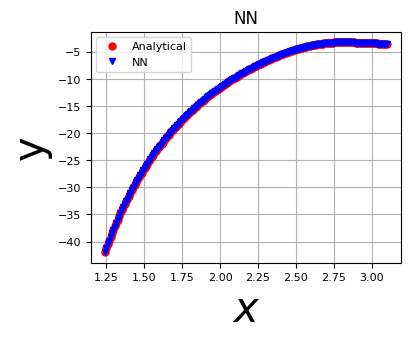

Analytical
NN


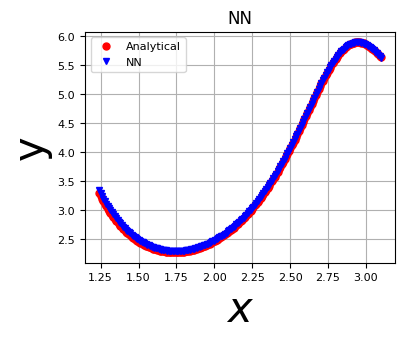

In [ ]:
# Plot results
#plot_score("./",history)

y_pred=model_fit.predict(whdata)
er_pred = y_pred[0]
ei_pred = y_pred[1]
#print(y_pred)
print(whdata.shape,er_pred.shape,ei_pred.shape)

GraphData([[whdata,erdata],[whdata,er_pred]], ["r","b"], ["Analytical","NN"],\
              [0,0,0],"NN", 'pp.png', Axx = "$x$", Axy = "y")

GraphData([[whdata,eidata],[whdata,ei_pred]], ["r","b"], ["Analytical","NN"],\
              [0,0,0],"NN", 'pp.png', Axx = "$x$", Axy = "y")

In [ ]:
params = model_fit.get_weights()

wplasma_pred = []
gamma_pred = []
Gamma_pred = []
Omega_pred = []
deps_pred = []
for d in range(D):
    wplasma_pred.append(float(params[1+2*d][0]))
    gamma_pred.append(float(params[2+2*d][0]))

for l in range(L):
    Gamma_pred.append(float(params[2*D+1+3*l][0]))
    Omega_pred.append(float(abs(params[2*D+2+3*l][0])))
    deps_pred.append(float(params[2*D+3+3*l][0]))

print(eps0,params[0][0])
print(wplasma,wplasma_pred)
print(gamma,gamma_pred)
print(Gamma,Gamma_pred)
print(Omega,Omega_pred)
print(deps,deps_pred)

1 [0.9996502]
[8.212] [8.213135719299316]
[0.03] [0.03086944669485092]
[0.378, 1.056, 3.213, 4.305] [0.3812043070793152, 1.0567208528518677, 3.2129440307617188, 4.305568695068359]
[0.291, 2.957, 5.3, 11.18] [0.2919890582561493, 2.9561808109283447, 5.298011779785156, 11.180091857910156]
[84.49, 1.395, 3.018, 0.598] [84.48763275146484, 1.394089698791504, 3.016970634460449, 0.597432017326355]


# Generation of training datasets

The training datasets are generated via the dielectric constant known functional form. First, we restrict the pairs $(D,\ L)$ we study limiting its values, $D=1,...,D_{max}$ and $L=1,...,L_{max}$. For each pair, we generate an N length dataset. And each data is a set of values of the dielectric constant $\epsilon(\omega)$ simulating real data. Even though, it is generated via the dielectric constant known functional form with randomly generated parameters. Each parameter has its own interval of generation based in real parameter values.

So, the next cellcode generates for each pair $(D,\ L)$ a set of spectrums with the parameters $\{\omega_{p_k},\gamma_k\}$ and $\{\Delta\varepsilon_k, \Omega_k, \Gamma_k\}$ randomly generated. The pair $(D,\ L)$ is also converted to categorical to make it readable for the neural network.

In [ ]:
'''
eps0 = 5.967
wplasma = [8.792]
gamma = [0.065]
Gamma = [0.433]
Omega = [2.684]
deps = [1.09]
'''
# El modelo de Drude-Lorentz tiene sentido físico para frecuencias > 0
# El rango razonable para el oro es 400nm-1000nm
# Frecuencias positivas en eV (w_eV=1240/lambda_nm)
#eps0 = 5.967

#Define wh range
n_sample = 200
wh0=1.24;whf=3.1
whdata = np.linspace(wh0,whf,n_sample)
eps0_lims = [1.,6.]
wplasma_lims = [3., 5.] #[3., 20.]
gamma_lims = [0.001, 0.1] #[0.01, 5.]
Gamma_lims = [0.01, 1.0] #[0.1, 6.]
Omega_lims = [1.0, 5.0] #[0.05, 20]
deps_lims = [0.1, 5.0] #[0.5, 20]

n_train = 6000
n_val = 500

D_max = 3
L_max = 4

Conj=[]
for i in range(1,D_max+1):
    for j in range(1,L_max+1):
        Conj.append([i,j])
print(Conj)

x = []
labels = []
DL_params=[]
er_func,ei_func=[],[]
max_func_target=[]
dict_cat_to_DL={}
for D,L in Conj:
    print((D-1)*L_max+L-1,D,L)
    dict_cat_to_DL[str((D-1)*L_max+L)]=[D,L]
    for i in range(n_train+n_val):
        eps0 = (eps0_lims[1] - eps0_lims[0])*np.random.rand() + eps0_lims[0]
        wplasma = (wplasma_lims[1] - wplasma_lims[0])*np.random.rand(D) + wplasma_lims[0]
        gamma = (gamma_lims[1] - gamma_lims[0])*np.random.rand(D) + gamma_lims[0]
        Gamma = (Gamma_lims[1] - Gamma_lims[0])*np.random.rand(L) + Gamma_lims[0]
        Omega = (Omega_lims[1] - Omega_lims[0])*np.random.rand(L) + Omega_lims[0]
        deps = (deps_lims[1] - deps_lims[0])*np.random.rand(L) + deps_lims[0]
        #print(wplasma,gamma,Gamma,Omega,deps)
        erdata,eidata = func_target(whdata,D,L,eps0,wplasma,gamma,Omega,Gamma,deps)
        er_func.append(erdata)
        ei_func.append(eidata)
        max_func=max(np.abs(np.min(erdata)),np.max(erdata))
        max_func_target.append(np.abs(max_func))
        #print(whdata)
        labels.append((D-1)*L_max+L-1)
        DL_params.append([D,L,eps0,wplasma,gamma,Omega,Gamma,deps])


labels = np.array(labels)
DL_params=np.array(DL_params)
max_func_target=np.array(max_func_target)
er_func=np.array(er_func)
ei_func=np.array(ei_func)
print(er_func.shape)

# Shuffle
shuffle_list = np.random.permutation(range(D_max*L_max*(n_val+n_train)))
print(type(shuffle_list))
labels = labels[shuffle_list]
DL_params = DL_params[shuffle_list]
max_func_target=max_func_target[shuffle_list]
er_func=er_func[shuffle_list]
ei_func=ei_func[shuffle_list]
print(type(labels),type(labels[0]))

# Labels to categorical
labels_cat = to_categorical(labels)

# Training, validation datasets
er_func_train=er_func[0:D_max*L_max*n_train]
ei_func_train=ei_func[0:D_max*L_max*n_train]
er_func_val=er_func[D_max*L_max*n_train:D_max*L_max*(n_train+n_val)]
ei_func_val=ei_func[D_max*L_max*n_train:D_max*L_max*(n_train+n_val)]
labels_cat_train = labels_cat[0:D_max*L_max*n_train]
labels_cat_val = labels_cat[D_max*L_max*n_train:D_max*L_max*(n_train+n_val)]

print(len(labels_cat_val),len(labels_cat_train))
print(labels[10],labels_cat[10])

[[1, 1], [1, 2], [1, 3], [1, 4], [2, 1], [2, 2], [2, 3], [2, 4], [3, 1], [3, 2], [3, 3], [3, 4]]
0 1 1
1 1 2
2 1 3
3 1 4
4 2 1
5 2 2
6 2 3
7 2 4
8 3 1
9 3 2
10 3 3
11 3 4


<ipython-input-7-0d3e08d577f0>:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  DL_params=np.array(DL_params)


(78000, 200)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.int64'>
6000 72000
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Plot $\varepsilon$ instances from the dataset

In [ ]:
y_test=labels_cat_train
params=DL_params
#print(np.min(x_test),np.max(x_test))

j=np.random.randint(0,len(y_test),size=(1,))
print("index=",j)

max_value=np.abs(max_func_target[j])
print(max_value)

D,L,eps0,wplasma,gamma,Omega,Gamma,deps=DL_params[j][0]
print(eps0,wplasma,gamma,Omega,Gamma,deps)
erdata,eidata=func_target(whdata,D,L,eps0,wplasma,gamma,Omega,Gamma,deps)
print(er_func[j,:].shape)

index= [6423]
[51.55590796]
4.024417345626992 [4.89494243 3.8269106 ] [0.0093369  0.09726133] [2.12720603 1.30338742 4.60320412] [0.270396   0.06519506 0.70955741] [2.53562599 4.40179585 4.41526507]
(1, 200)


# Neural Network definition

Once the dataset is generated, we use it to train the neural network.


In [ ]:
from keras import models
from keras import layers

model = models.Sequential()

layers_size = 64
epochs = 200
batch_size = 64

input_real=layers.Input(shape=(200,))
input_imag=layers.Input(shape=(200,))

x=layers.Dense(layers_size,activation='relu')(input_real)
out_real=layers.Dense(layers_size,activation='relu')(x)

x=layers.Dense(layers_size,activation='relu')(input_imag)
out_imag=layers.Dense(layers_size,activation='relu')(x)

output_concat=layers.concatenate([out_real,out_imag])
x=layers.Dense(64,activation='relu')(output_concat)
output=layers.Dense(12,activation='softmax')(x)

model=Model([input_real,input_imag],output)
model.summary()

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# x=eps_r spectra
history = model.fit([er_func_train/max_value,ei_func_train/max_value],labels_cat_train,
                    epochs = epochs,
                    batch_size=batch_size,
                    validation_data=([er_func_val/max_value,ei_func_val/max_value],labels_cat_val))


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 dense_6 (Dense)             (None, 64)                   12864     ['input_3[0][0]']             
                                                                                                  
 dense_8 (Dense)             (None, 64)                   12864     ['input_4[0][0]']             
                                                                                            

KeyboardInterrupt: ignored

# Plot Neural Network history

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


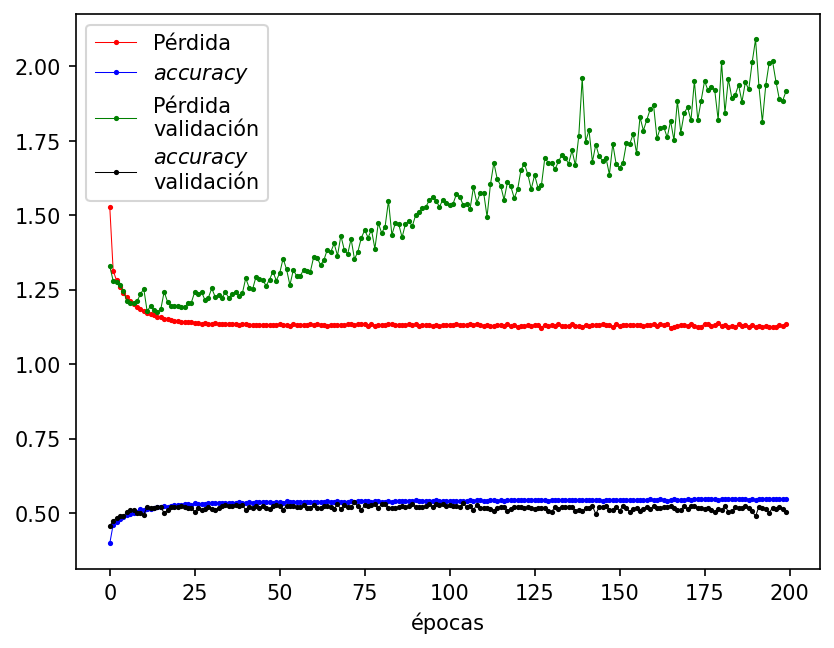

In [ ]:
# Plot true vs predicted
color=['red','blue','green','black']
plt.figure(dpi=150)
labels = ['Pérdida', '$\mathit{accuracy}$', 'Pérdida\nvalidación', '$\mathit{accuracy}$\nvalidación']
for i,key in enumerate(history.history.keys()):
  plt.plot(history.epoch,history.history[key], color=color[i], linewidth=0.5, marker='.', markersize=3,label=labels[i])

plt.xlabel('épocas')
plt.legend()
plt.savefig(f"{images_dir}/NNinfo.png",dpi=640)
plt.show()

# Results: neural network prediction against true values

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 dense_18 (Dense)            (None, 64)                   12864     ['input_7[0][0]']             
                                                                                                  
 dense_20 (Dense)            (None, 64)                   12864     ['input_8[0][0]']             
                                                                                            

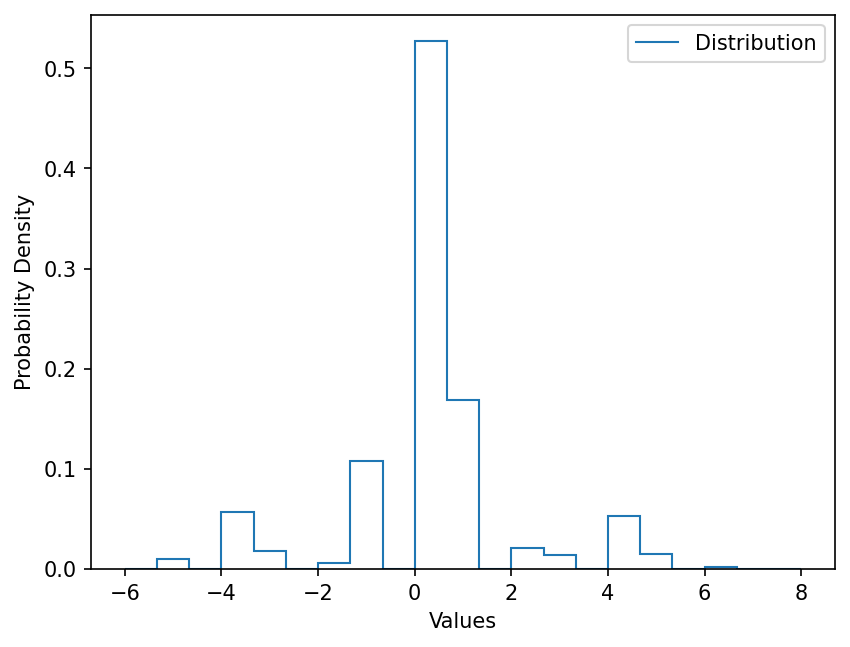

In [ ]:
model.summary()

# Choose the test data
x_test=[er_func_val/max_value,ei_func_val/max_value]
y_test=labels_cat_val
score = model.evaluate(x_test, y_test, verbose=1)

# Check validation dataset
y_pred=np.argmax(model.predict(x_test),axis=1)
y_true=np.argmax(y_test,axis=1)

# Plot histogram
plt.figure(dpi=150)
counts, bins = np.histogram(y_true-y_pred,bins=21)
print(counts,bins)
plt.stairs(counts/np.sum(counts), bins,label='Distribution')
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [ ]:
# Choose the test data
x_test=[er_func_val/max_value,ei_func_val/max_value]
y_test=labels_cat_val
score = model.evaluate(x_test, y_test, verbose=1)

# Check validation dataset
y_pred=np.argmax(model.predict(x_test),axis=1)
y_true=np.argmax(y_test,axis=1)

188/188 [==============================] - 0s 2ms/step


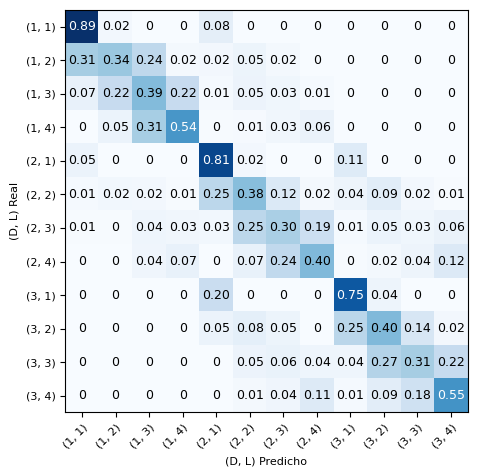

In [ ]:
colormap = np.zeros((12,12))

for i in range(len(y_pred)):
    colormap[y_true[i]][y_pred[i]] += 1
for i in range(len(colormap)):
    colormap[i] = colormap[i]/np.sum(colormap[i])

Conj_str=[]
for i in range(1,D_max+1):
    for j in range(1,L_max+1):
        Conj_str.append(f"({i}, {j})")

fig, ax = plt.subplots()
im = ax.imshow(colormap,cmap='Blues')#viridis,Blues,Greys,PuBu,PuRd,gist_greys

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(Conj_str)), labels=Conj_str)
ax.set_yticks(np.arange(len(Conj_str)), labels=Conj_str)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(Conj_str)):
    for j in range(len(Conj_str)):
        #print(float(colormap[i][j]):.2e)
        if float(f"{colormap[i, j]:.2f}")<0.01:
            value = f"{colormap[i, j]:.0f}"
        else:
            value = f"{colormap[i, j]:.2f}"
        if float(f"{colormap[i, j]:.2f}")>0.5:
            color="w"
        else:
            color="black"
        text = ax.text(j, i, value,
                       ha="center", va="center", color=color,size=9)

ax.set_ylabel("(D, L) Real")
ax.set_xlabel("(D, L) Predicho")
fig.tight_layout()
#plt.savefig(f"{images_dir}/DLmatrix_v2.png",dpi=640)
plt.show()

## Plot $\varepsilon$: true vs predicted

In [ ]:
# Choose the test data
x_test=[er_func/max_value,ei_func/max_value]
y_test=labels_cat

# Check validation dataset
y_pred=np.argmax(model.predict(x_test),axis=1)
y_true=np.argmax(y_test,axis=1)

2438/2438 [==============================] - 8s 3ms/step


In [ ]:
j=np.random.randint(0,len(x_test[0]),size=(1,))
print("index=",j)
print("True=",y_true[j])
print("Pred=",y_pred[j])

# True values
D,L,eps0,wplasma,gamma,Omega,Gamma,deps=DL_params[j][0]
print("(D,L) true=",D,L)
erdata_true,eidata_true=func_target(whdata,D,L,eps0,wplasma,gamma,Omega,Gamma,deps)

D_pred,L_pred =dict_cat_to_DL[str(y_pred[j][0]+1)]
print("(D,L) pred=",D_pred,L_pred)


index= [52983]
True= [1]
Pred= [1]
(D,L) true= 1 2
(D,L) pred= 1 2


In [ ]:
D,L,eps0,wplasma,gamma,Omega,Gamma,deps=DL_params[j][0]
print("(D,L) true=",D,L)
erdata_true,eidata_true=func_target(whdata,D,L,eps0,wplasma,gamma,Omega,Gamma,deps)

D_pred,L_pred =dict_cat_to_DL[str(y_pred[j][0]+1)]
print("(D,L) pred=",D_pred,L_pred)

#shuffle the data
shuffle_list = np.random.permutation(range(n_sample))
print(shuffle_list)
whdata = whdata[shuffle_list]
erdata = erdata[shuffle_list]
eidata = eidata[shuffle_list]
#erdata = (erdata - np.mean(erdata))/np.std(erdata)
#eidata = (eidata - np.mean(eidata))/np.std(eidata)
#e_std = np.sqrt(np.std(erdata)**2+np.std(eidata)**2)
#erdata = (erdata)/e_std
#eidata = (eidata)/e_std
#print(max(erdata),max(eidata))


#Check data and labels previously defined
'''print(wh_train.shape[0],'train samples')
print(wh_val.shape[0],'test samples')
print("wh_train shape",wh_train.shape)
print("er & ei shapes",er_train.shape,ei_train.shape)'''

# Input and output neurons (from the data)
input_neurons  = 1
output_neurons = 1

# Hiperparameters
batch_size = 32
epochs = 100

delta=np.random.rand()
print(delta)

# Using sympy to define functions

wh_sym = sym.symbols("wh")
wplasma_sym = [sym.symbols(f"wp{d}") for d in range(D_pred)]
gamma_sym = [sym.symbols(f"g{d}") for d in range(D_pred)]

funcsDrude_list_r=[-wplasma_sym[d]**2/(wh_sym**2+gamma_sym[d]**2) for d in range(D_pred)]
funcsDrude_list_i=[(gamma_sym[d]/wh_sym)*wplasma_sym[d]**2/(wh_sym**2+gamma_sym[d]**2) for d in range(D_pred)]


Gamma_sym = [sym.symbols(f"G{l}") for l in range(L_pred)]
Omega_sym = [sym.symbols(f"O{l}") for l in range(L_pred)]
deps_sym = [sym.symbols(f"deps{l}") for l in range(L_pred)]


funcsLorentz_list_r=[-(deps_sym[l]*Omega_sym[l]**2)/((wh_sym**2 - Omega_sym[l]**2)**2+(Gamma_sym[l]*wh_sym)**2)*(wh_sym**2 - Omega_sym[l]**2) for l in range(L_pred)]
funcsLorentz_list_i=[((deps_sym[l]*Omega_sym[l]**2)/((wh_sym**2 - Omega_sym[l]**2)**2+(Gamma_sym[l]*wh_sym)**2))*(Gamma_sym[l]*wh_sym) for l in range(L_pred)]

eps0_sym = sym.symbols("eps0")

funcsDrude_list_r=[lambdify([wh_sym,wplasma_sym[d],gamma_sym[d]],funcsDrude_list_r[d], 'numpy') for d in range(D_pred)]
funcsDrude_list_i=[lambdify([wh_sym,wplasma_sym[d],gamma_sym[d]],funcsDrude_list_i[d], 'numpy') for d in range(D_pred)]

funcsLorentz_list_r=[lambdify([wh_sym,Omega_sym[l],Gamma_sym[l],deps_sym[l]],funcsLorentz_list_r[l], 'numpy') for l in range(L_pred)]
funcsLorentz_list_i=[lambdify([wh_sym,Omega_sym[l],Gamma_sym[l],deps_sym[l]],funcsLorentz_list_i[l], 'numpy') for l in range(L_pred)]


#Initial parameter values
eps0_ini = eps0
print(eps0,eps0_ini)

wplasma_ini = wplasma
gamma_ini = gamma
print(wplasma,wplasma_ini,gamma,gamma_ini)

Omega_ini = Omega
Gamma_ini = Gamma
deps_ini = deps
print(Omega,Omega_ini,Gamma,Gamma_ini,deps,deps_ini)

# Define the function Keras layers
FuncLayerDrude_list = [FuncLayer_Drude(output_neurons,[wplasma_ini[d],gamma_ini[d]]) for d in range(D_pred)]
FuncLayerLorentz_list = [FuncLayer_Lorentz(output_neurons,[Omega_ini[l],Gamma_ini[l],deps_ini[l]]) for l in range(L_pred)]
FuncCons = FuncLayer_eps0(output_neurons,eps0_ini)

# Define the model (several layers in parallel)
input=tf.keras.layers.Input((input_neurons,))
sum_layers_r=[FuncCons(input)] + [FuncLayerDrude_list[d](input,funcsDrude_list_r[d]) for d in range(D)] + [FuncLayerLorentz_list[l](input,funcsLorentz_list_r[l]) for l in range(L_pred)]
sum_layers_i=[FuncLayerDrude_list[d](input,funcsDrude_list_i[d]) for d in range(D)] + [FuncLayerLorentz_list[l](input,funcsLorentz_list_i[l]) for l in range(L_pred)]
#print(sum_layers_r, sum_layers_i)
output_r = tf.keras.layers.Add()(sum_layers_r)
output_i = tf.keras.layers.Add()(sum_layers_i)
#print(output_r,output_i)
model_fit=Model(input,[output_r,output_i])

model_fit.summary()
print(model_fit.weights[0:2])

# Define the metrics, optimizer and loss
optimizer=RMSprop()
loss=tf.keras.losses.mean_squared_error
metrics=tf.keras.metrics.MeanSquaredError()

# Compile
model_fit.compile(loss=loss,
              #loss_weights = [1,2],
          optimizer=optimizer,
          metrics=metrics)

history = model_fit.fit(whdata, [erdata,eidata],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)#,
                    #validation_data=(wh_val, [er_val,ei_val]))

(D,L) true= 3 1
(D,L) pred= 3 1
[158  12  30  87 161 145 129  57 110 157  38 141  32 130 126 148  42 183
  40  24 122 135  91 193  84  90  80 105 112 181   1 196  52  60 155  65
   9 118 109  78  63 198  33 176 190  97 107  47 188 147 195 128  82  66
 178  27  45 151  31  71 102 163  96 162  62 159 185 186  28 180  49 152
 100 156  88  44 143  76   0 169 142  94  21 106 134 113 184  95  16 165
  23   3 108  51 179 149  86  64  70  85  72 127 187 125 168 177  17  34
  10  35 172 115 124 182 191  18  55 121  43 101 171   6  67  13 144 104
 170  77  29 164 120  59   2 150 154  99 153 194 192  58  53 123  75  56
 103 138   8 167  89 116 139  68 173  48  41  79  37  54 132  74 175  92
 189 199 140  26  61  19  73 131  11  50 111 117  25  22 119 136   4 114
  46  98  15 160  36   7  93  14  69  39  81  20 133 137  83 174 146   5
 166 197]
0.4322143388691706
1 1
[4.32141753 3.61462235 4.14681854] [4.32141753 3.61462235 4.14681854] [0.03196939 0.06706191 0.02850855] [0.03196939 0.06706191 0.02

[array([[1.7013427]], dtype=float32), array([[3.6238446]], dtype=float32), array([[-0.]], dtype=float32), array([[2.9174523]], dtype=float32), array([[-0.]], dtype=float32), array([[3.449302]], dtype=float32), array([[-0.]], dtype=float32), array([[0.77652216]], dtype=float32), array([[1.1840712]], dtype=float32), array([[3.9201994]], dtype=float32)] 10
1 [1.7013427]
[4.32141753 3.61462235 4.14681854] [3.623844623565674, 2.917452335357666, 3.4493019580841064]
[0.03196939 0.06706191 0.02850855] [-0.0, -0.0, -0.0]
[1.6931477] [0.776522159576416]
[0.14792928] [1.1840711832046509]
[4.58734231] [3.920199394226074]
(None, 1) (1, 1)
(None, 1) (1, 1)
(None, 1) (1, 1)
(1, 1)
(None, 1) (1, 1)
(None, 1) (1, 1)
(None, 1) (1, 1)
7/7 [==============================] - 0s 2ms/step
Datos
Ajuste


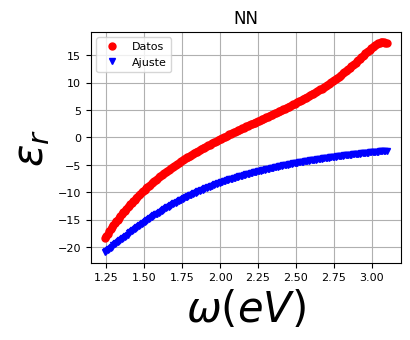

Datos
Ajuste


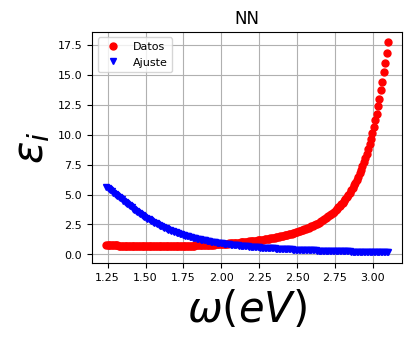

In [ ]:
params = model_fit.get_weights()
print(params,len(params))

wplasma_pred = []
gamma_pred = []
Gamma_pred = []
Omega_pred = []
deps_pred = []
for d in range(D_pred):
    wplasma_pred.append(float(params[1+2*d][0]))
    gamma_pred.append(float(params[2+2*d][0]))

for l in range(L_pred):
    Omega_pred.append(float(params[2*D_pred+1+3*l][0]))
    Gamma_pred.append(float(abs(params[2*D_pred+2+3*l][0])))
    deps_pred.append(float(params[2*D_pred+3+3*l][0]))

print(eps0,params[0][0])
print(wplasma,wplasma_pred)
print(gamma,gamma_pred)
print(Omega,Omega_pred)
print(Gamma,Gamma_pred)
print(deps,deps_pred)


erdata_pred,eidata_pred=model_fit.predict(whdata)

GraphData([[whdata,np.squeeze(erdata)],[whdata,erdata_pred]], ["r","b"], ["Datos","Ajuste"],\
              [0,0,0],"NN", 'pp.png', Axx = "$\omega (eV)$", Axy = '$\epsilon_r$')


GraphData([[whdata,np.squeeze(eidata)],[whdata,eidata_pred]], ["r","b"], ["Datos","Ajuste"],\
              [0,0,0],"NN", 'pp.png', Axx = "$\omega (eV)$", Axy = "$\epsilon_i$")

## Alternative: least_squares

In [ ]:


from scipy.optimize import least_squares

def func(wh,D,L,params):#,eps0,wplasma,gamma,Omega,Gamma,deps):
    '''
    Comentar
    '''
    eps0 = params[0]
    wplasma = params[1:D+1]
    gamma = params[D+1:2*D+1]
    Omega = params[2*D+1:2*D+L+1]
    Gamma = params[2*D+L+1:2*(D+L)+1]
    deps = params[2*(D+L)+1:2*D+3*L+1]
    #print(eps0,wplasma,gamma,Omega,Gamma,deps)
    er = eps0
    ei = 0
    for d in range(D):
        er -= wplasma[d]**2/(wh**2 + gamma[d]**2)
        ei += (gamma[d]/wh)*(wplasma[d]**2/(wh**2 + gamma[d]**2))
    for l in range(L):
        er -= (deps[l]*Omega[l]**2)/((wh**2 - Omega[l]**2)**2+(Gamma[l]*wh)**2)*(wh**2 - Omega[l]**2)
        ei += ((deps[l]*Omega[l]**2)/((wh**2 - Omega[l]**2)**2+(Gamma[l]*wh)**2))*(Gamma[l]*wh)
    return er,ei

def Build_residuals(f,D,L,wh,er,ei):
    def residual(params):
        #print(params)
        fun = f(wh,D,L,params)
        return np.sqrt((fun[0]-er)**2+(fun[1]-ei)**2)
    return residual

'''
eps0,wplasma,gamma,Omega,Gamma,deps = FUNCION_AJUSTE GUILLEM
'''
#Initial parameter values

sigma_err=0.05

eps0_ini = eps0 * (1+sigma_err*np.random.randn())
print(eps0,eps0_ini)

wplasma_ini = wplasma*(1 + sigma_err*np.random.randn(D_pred))
gamma_ini = gamma*(1+sigma_err*np.random.randn(D_pred))
print(wplasma,wplasma_ini,gamma,gamma_ini)

Gamma_ini = Gamma*(1+sigma_err*np.random.randn(L_pred))
Omega_ini = Omega*(1+sigma_err*np.random.randn(L_pred))
deps_ini = deps*(1+sigma_err*np.random.randn(L_pred))
print(Gamma,Gamma_ini,Omega,Omega_ini,deps,deps_ini)
print(type(Gamma_ini))
params_ini = np.concatenate(([eps0_ini],wplasma_ini,gamma_ini,Omega_ini,Gamma_ini,deps_ini))
print(params_ini)

optimization = least_squares(Build_residuals(func,D_pred,L_pred,whdata,erdata_Au,eidata_Au),params_ini)

5.967 5.8075868497564205
[8.792] [9.38076649 8.92376689 8.81468197] [0.065] [0.07232186 0.06562754 0.06145166]
[0.433] [0.44939764] [2.684] [2.56066297] [1.09] [1.19056879]
<class 'numpy.ndarray'>
[5.80758685 9.38076649 8.92376689 8.81468197 0.07232186 0.06562754
 0.06145166 2.56066297 0.44939764 1.19056879]


5.966999041594171 [4.77416761] [0.01539622] [4.28685207] [0.24568141] [3.93068722]
5.967 [4.77416765] [0.01539622] [4.28685193] [0.24568141] [3.93068653]
Datos
Ajuste


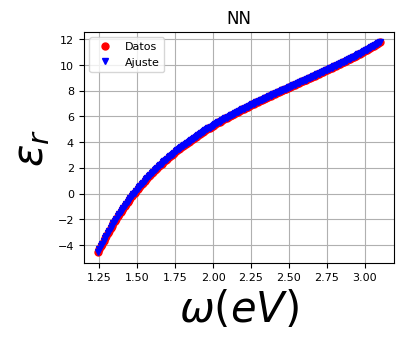

Datos
Ajuste


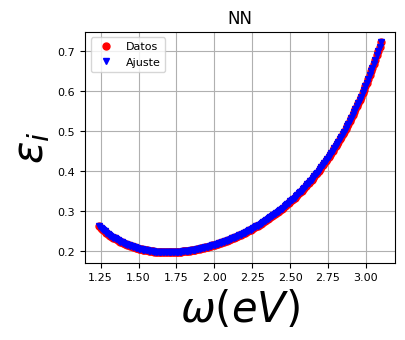

In [ ]:
params_pred = optimization.x

eps0_pred = params_pred[0]
wplasma_pred = params_pred[1:D+1]
gamma_pred = params_pred[D+1:2*D+1]
Omega_pred = params_pred[2*D+1:2*D+L+1]
Gamma_pred = params_pred[2*D+L+1:2*(D+L)+1]
deps_pred = params_pred[2*(D+L)+1:2*D+3*L+1]

print(eps0_pred,wplasma_pred,gamma_pred,Omega_pred,Gamma_pred,deps_pred)
print(eps0,wplasma,gamma,Omega,Gamma,deps)

#erdata_pred,eidata_pred=func_target(whdata,D_pred,L_pred,eps0_pred,wplasma_pred,gamma_pred,Omega_pred,Gamma_pred,deps_pred)
erdata_pred,eidata_pred=func(whdata,D_pred,L_pred,params_pred)

GraphData([[whdata,np.squeeze(erdata_true)],[whdata,erdata_pred]], ["r","b"], ["Datos","Ajuste"],\
              [0,0,0],"least_squares", 'pp.png', Axx = "$\omega (eV)$", Axy = '$\epsilon_r$')


GraphData([[whdata,np.squeeze(eidata_true)],[whdata,eidata_pred]], ["r","b"], ["Datos","Ajuste"],\
              [0,0,0],"least_squares", 'pp.png', Axx = "$\omega (eV)$", Axy = "$\epsilon_i$")

### Prediction to Gold Data

200 200


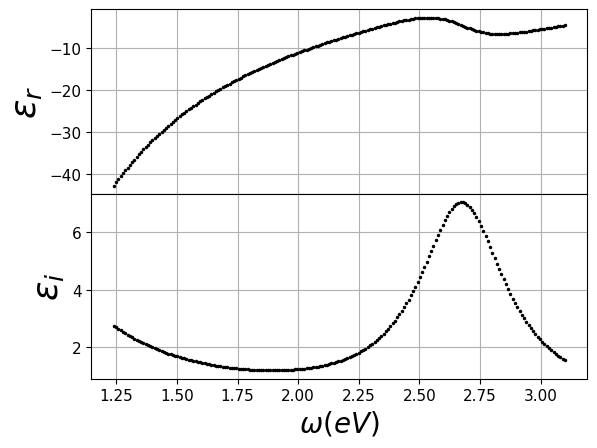

1/1 [==============================] - 0s 50ms/step
[[0.0000000e+00 3.5253068e-30 4.8169381e-32 2.5982706e-28 8.6729554e-22
  9.1794965e-22 1.3060595e-20 9.1443460e-20 9.9967551e-01 3.2453056e-04
  1.9076671e-08 1.4178958e-08]] [8]
(D,L) pred= 3 1


In [ ]:
eps0 = 5.967
wplasma = [8.792]
gamma = [0.065]
Gamma = [0.433]
Omega = [2.684]
deps = [1.09]

erdata_Au,eidata_Au=func_target(whdata,1,1,eps0,wplasma,gamma,Omega,Gamma,deps)

print(len(erdata_Au),len(eidata_Au))

x_data = [np.array([erdata_Au/max_value]),np.array([eidata_Au/max_value])]
fig, axs = plt.subplots(2, 1, sharex=True)
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
# Plot each graph, and manually set the y tick values
axs[0].plot(whdata,erdata_Au,'o',c='black',markersize=1.5)
axs[1].plot(whdata,eidata_Au,'o',c='black',markersize=1.5)
    #axs[0].plot(whdata,erdata_g[i],'-',c='r',markersize=1.5)
    #axs[1].plot(whdata,eidata_g[i],'-',c='r',markersize=1.5)

#axs[0].set_xticks(fontsize=12)
#axs[0].set_yticks(fontsize=12)
#axs[1].set_yticks(fontsize=12)
axs[0].grid()
axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=11)
axs[0].tick_params(axis='y', which='major', labelsize=11)
axs[0].set_ylabel('$\epsilon_r$',size=26)
axs[1].set_ylabel('$\epsilon_i$',size=26)
plt.xlabel('$\omega(eV)$',size=20)

plt.savefig(f"{images_dir}/espectr_Au.png")
plt.show()
predic = model.predict(x_data)
y_pred=np.argmax(predic,axis=1)
print(predic,y_pred)
D_pred,L_pred =dict_cat_to_DL[str(y_pred[0]+1)]
print("(D,L) pred=",D_pred,L_pred)

In [ ]:
# Input and output neurons (from the data)
input_neurons  = 1
output_neurons = 1

# Hiperparameters
batch_size = 32
epochs = 1800

delta=np.random.rand()
print(delta)

# Using sympy to define functions

wh_sym = sym.symbols("wh")
wplasma_sym = [sym.symbols(f"wp{d}") for d in range(D_pred)]
gamma_sym = [sym.symbols(f"g{d}") for d in range(D_pred)]

funcsDrude_list_r=[-wplasma_sym[d]**2/(wh_sym**2+gamma_sym[d]**2) for d in range(D_pred)]
funcsDrude_list_i=[(gamma_sym[d]/wh_sym)*wplasma_sym[d]**2/(wh_sym**2+gamma_sym[d]**2) for d in range(D_pred)]


Gamma_sym = [sym.symbols(f"G{l}") for l in range(L_pred)]
Omega_sym = [sym.symbols(f"O{l}") for l in range(L_pred)]
deps_sym = [sym.symbols(f"deps{l}") for l in range(L_pred)]


funcsLorentz_list_r=[-(deps_sym[l]*Omega_sym[l]**2)/((wh_sym**2 - Omega_sym[l]**2)**2+(Gamma_sym[l]*wh_sym)**2)*(wh_sym**2 - Omega_sym[l]**2) for l in range(L_pred)]
funcsLorentz_list_i=[((deps_sym[l]*Omega_sym[l]**2)/((wh_sym**2 - Omega_sym[l]**2)**2+(Gamma_sym[l]*wh_sym)**2))*(Gamma_sym[l]*wh_sym) for l in range(L_pred)]

eps0_sym = sym.symbols("eps0")

funcsDrude_list_r=[lambdify([wh_sym,wplasma_sym[d],gamma_sym[d]],funcsDrude_list_r[d], 'numpy') for d in range(D_pred)]
funcsDrude_list_i=[lambdify([wh_sym,wplasma_sym[d],gamma_sym[d]],funcsDrude_list_i[d], 'numpy') for d in range(D_pred)]

funcsLorentz_list_r=[lambdify([wh_sym,Omega_sym[l],Gamma_sym[l],deps_sym[l]],funcsLorentz_list_r[l], 'numpy') for l in range(L_pred)]
funcsLorentz_list_i=[lambdify([wh_sym,Omega_sym[l],Gamma_sym[l],deps_sym[l]],funcsLorentz_list_i[l], 'numpy') for l in range(L_pred)]


#Initial parameter values
eps0_ini = eps0
print(eps0,eps0_ini)

wplasma_ini = [wplasma for d in range(D_pred)]
gamma_ini = [gamma for d in range(D_pred)]
print(wplasma,wplasma_ini,gamma,gamma_ini)

Omega_ini = [Omega for l in range(L_pred)]
Gamma_ini = [Gamma for l in range(L_pred)]
deps_ini = [deps for l in range(L_pred)]
print(Omega,Omega_ini,Gamma,Gamma_ini,deps,deps_ini)

# Define the function Keras layers
FuncLayerDrude_list = [FuncLayer_Drude(output_neurons,[wplasma_ini[d],gamma_ini[d]]) for d in range(D_pred)]
FuncLayerLorentz_list = [FuncLayer_Lorentz(output_neurons,[Omega_ini[l],Gamma_ini[l],deps_ini[l]]) for l in range(L_pred)]
FuncCons = FuncLayer_eps0(output_neurons,eps0_ini)

# Define the model (several layers in parallel)
input=tf.keras.layers.Input((input_neurons,))
sum_layers_r=[FuncCons(input)] + [FuncLayerDrude_list[d](input,funcsDrude_list_r[d]) for d in range(D)] + [FuncLayerLorentz_list[l](input,funcsLorentz_list_r[l]) for l in range(L_pred)]
sum_layers_i=[FuncLayerDrude_list[d](input,funcsDrude_list_i[d]) for d in range(D)] + [FuncLayerLorentz_list[l](input,funcsLorentz_list_i[l]) for l in range(L_pred)]
#print(sum_layers_r, sum_layers_i)
output_r = tf.keras.layers.Add()(sum_layers_r)
output_i = tf.keras.layers.Add()(sum_layers_i)
#print(output_r,output_i)
model_fit=Model(input,[output_r,output_i])

model_fit.summary()
print(model_fit.weights[0:2])

# Define the metrics, optimizer and loss
optimizer=RMSprop()
loss=tf.keras.losses.mean_squared_error
metrics=tf.keras.metrics.MeanSquaredError()

# Compile
model_fit.compile(loss=loss,
              #loss_weights = [1,2],
          optimizer=optimizer,
          metrics=metrics)

history = model_fit.fit(whdata, [erdata_Au,eidata_Au],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

0.7178082610013016
5.967 5.967
[8.792] [[8.792], [8.792], [8.792]] [0.065] [[0.065], [0.065], [0.065]]
[2.684] [[2.684]] [0.433] [[0.433]] [1.09] [[1.09]]
(1, 1)
(None, 1) (1, 1)
(None, 1) (1, 1)
(None, 1) (1, 1)
(None, 1) (1, 1)
(None, 1) (1, 1)
(None, 1) (1, 1)
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 func_layer_eps0_4 (FuncLay  (None, 1)                    1         ['input_17[0][0]']            
 er_eps0)                                                                                         
                                                                                                  
 func_layer__drude_13 (Fu

[array([[5.9671335]], dtype=float32), array([[5.075934]], dtype=float32), array([[0.06597513]], dtype=float32), array([[5.075934]], dtype=float32), array([[0.06597513]], dtype=float32), array([[5.075934]], dtype=float32), array([[0.06597513]], dtype=float32), array([[0.43270135]], dtype=float32), array([[2.6839318]], dtype=float32), array([[1.0905368]], dtype=float32)] 10
5.967 [5.9671335]
[8.792] [5.075933933258057, 5.075933933258057, 5.075933933258057]
[0.065] [0.0659751296043396, 0.0659751296043396, 0.0659751296043396]
[2.684] [0.43270134925842285]
[0.433] [2.683931827545166]
[1.09] [1.0905368328094482]
(None, 1) (1, 1)
(None, 1) (1, 1)
(None, 1) (1, 1)
(1, 1)
(None, 1) (1, 1)
(None, 1) (1, 1)
(None, 1) (1, 1)
7/7 [==============================] - 0s 3ms/step


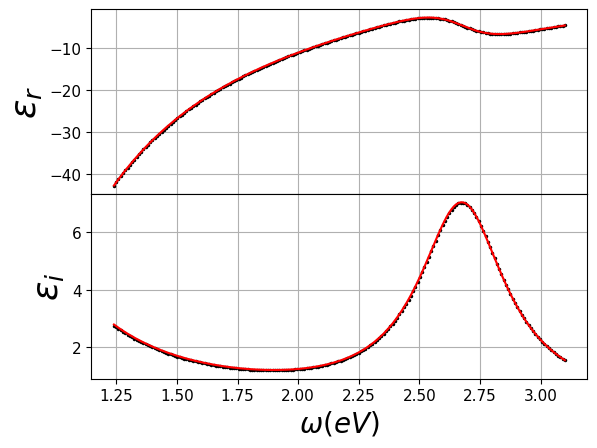

In [ ]:
params = model_fit.get_weights()
print(params,len(params))

wplasma_pred = []
gamma_pred = []
Gamma_pred = []
Omega_pred = []
deps_pred = []
for d in range(D_pred):
    wplasma_pred.append(float(params[1+2*d][0]))
    gamma_pred.append(float(params[2+2*d][0]))

for l in range(L_pred):
    Omega_pred.append(float(params[2*D_pred+1+3*l][0]))
    Gamma_pred.append(float(abs(params[2*D_pred+2+3*l][0])))
    deps_pred.append(float(params[2*D_pred+3+3*l][0]))

print(eps0,params[0][0])
print(wplasma,wplasma_pred)
print(gamma,gamma_pred)
print(Omega,Omega_pred)
print(Gamma,Gamma_pred)
print(deps,deps_pred)


erdata_pred,eidata_pred=model_fit.predict(whdata)

fig, axs = plt.subplots(2, 1, sharex=True)
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
# Plot each graph, and manually set the y tick values
axs[0].plot(whdata,erdata_Au,'o',c='black',markersize=1.5)
axs[1].plot(whdata,eidata_Au,'o',c='black',markersize=1.5)
axs[0].plot(whdata,erdata_pred,'-',c='r',markersize=1.5)
axs[1].plot(whdata,eidata_pred,'-',c='r',markersize=1.5)
    #axs[0].plot(whdata,erdata_g[i],'-',c='r',markersize=1.5)
    #axs[1].plot(whdata,eidata_g[i],'-',c='r',markersize=1.5)

#axs[0].set_xticks(fontsize=12)
#axs[0].set_yticks(fontsize=12)
#axs[1].set_yticks(fontsize=12)
axs[0].grid()
axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=11)
axs[0].tick_params(axis='y', which='major', labelsize=11)
axs[0].set_ylabel('$\epsilon_r$',size=26)
axs[1].set_ylabel('$\epsilon_i$',size=26)
plt.xlabel('$\omega(eV)$',size=20)

plt.savefig(f"{images_dir}/espectr_predNN_Au.png")
plt.show()

In [ ]:
# Choose the test data
x_test=[er_func/max_value,ei_func/max_value]
y_test=labels_cat

# Check validation dataset
y_pred=np.argmax(model.predict(x_test),axis=1)
y_true=np.argmax(y_test,axis=1)


2438/2438 [==============================] - 4s 2ms/step


In [ ]:
j=np.random.randint(0,len(x_test[0]),size=(1,))
j=[9]
print("index=",j)
print("True=",y_true[j])
print("Pred=",y_pred[j])

# True values
D,L,eps0,wplasma,gamma,Omega,Gamma,deps=DL_params[j][0]
print("(D,L) true=",D,L)
erdata_true,eidata_true=func_target(whdata,D,L,eps0,wplasma,gamma,Omega,Gamma,deps)

D_pred,L_pred =dict_cat_to_DL[str(y_pred[j][0]+1)]
print("(D,L) pred=",D_pred,L_pred)

index= [9]
True= [0]
Pred= [0]
(D,L) true= 1 1
(D,L) pred= 1 1


In [ ]:


from scipy.optimize import least_squares

def func(wh,D,L,params):#,eps0,wplasma,gamma,Omega,Gamma,deps):
    '''
    Similar function to func_target but adapted to work with least_squares
    '''
    eps0 = params[0]
    wplasma = params[1:D+1]
    gamma = params[D+1:2*D+1]
    Omega = params[2*D+1:2*D+L+1]
    Gamma = params[2*D+L+1:2*(D+L)+1]
    deps = params[2*(D+L)+1:2*D+3*L+1]
    #print(eps0,wplasma,gamma,Omega,Gamma,deps)
    er = eps0
    ei = 0
    for d in range(D):
        er -= wplasma[d]**2/(wh**2 + gamma[d]**2)
        ei += (gamma[d]/wh)*(wplasma[d]**2/(wh**2 + gamma[d]**2))
    for l in range(L):
        er -= (deps[l]*Omega[l]**2)/((wh**2 - Omega[l]**2)**2+(Gamma[l]*wh)**2)*(wh**2 - Omega[l]**2)
        ei += ((deps[l]*Omega[l]**2)/((wh**2 - Omega[l]**2)**2+(Gamma[l]*wh)**2))*(Gamma[l]*wh)
    return er,ei

def Build_residuals(f,D,L,wh,er,ei):
    def residual(params):
        #print(params)
        fun = f(wh,D,L,params)
        return np.sqrt((fun[0]-er)**2+(fun[1]-ei)**2)
    return residual

#Initial parameter values

sigma_err=.001

eps0_ini = eps0 * (1+sigma_err*np.random.randn())
print(eps0,eps0_ini)

wplasma_ini = wplasma*(1 + sigma_err*np.random.randn(D_pred))
gamma_ini = gamma*(1+sigma_err*np.random.randn(D_pred))
print(wplasma,wplasma_ini,gamma,gamma_ini)

Gamma_ini = Gamma*(1+sigma_err*np.random.randn(L_pred))
Omega_ini = Omega*(1+sigma_err*np.random.randn(L_pred))
deps_ini = deps*(1+sigma_err*np.random.randn(L_pred))
print(Gamma,Gamma_ini,Omega,Omega_ini,deps,deps_ini)
print(type(Gamma_ini))
params_ini = np.concatenate(([eps0_ini],wplasma_ini,gamma_ini,Omega_ini,Gamma_ini,deps_ini))
print(params_ini)

optimization = least_squares(Build_residuals(func,D_pred,L_pred,whdata,erdata_true,eidata_true),params_ini)

5.967 5.97176854555711
[4.77416765] [4.77063579] [0.01539622] [0.01538079]
[0.24568141] [0.24552562] [4.28685193] [4.29437017] [3.93068653] [3.92739148]
<class 'numpy.ndarray'>
[5.97176855 4.77063579 0.01538079 4.29437017 0.24552562 3.92739148]


5.967030900885697 [8.79199999 0.0678165  0.11047053] [  0.0649996  -14.49691155  37.14934721] [2.68399982] [0.43299954] [1.08999907]
5.967 [8.792] [0.065] [2.684] [0.433] [1.09]


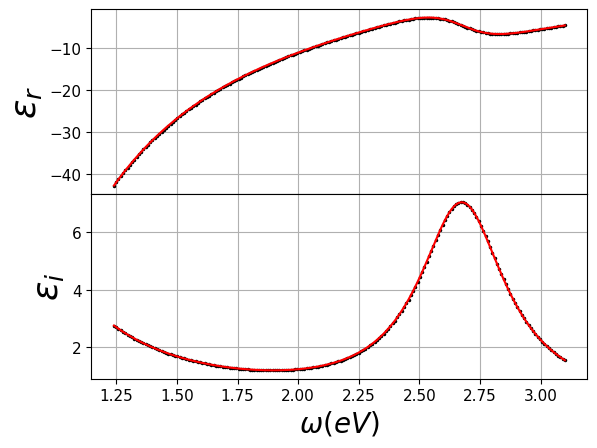

In [ ]:
params_pred = optimization.x

eps0_pred = params_pred[0]
wplasma_pred = params_pred[1:D_pred+1]
gamma_pred = params_pred[D_pred+1:2*D_pred+1]
Omega_pred = params_pred[2*D_pred+1:2*D_pred+L_pred+1]
Gamma_pred = params_pred[2*D_pred+L_pred+1:2*(D+L_pred)+1]
deps_pred = params_pred[2*(D_pred+L_pred)+1:2*D_pred+3*L_pred+1]

print(eps0_pred,wplasma_pred,gamma_pred,Omega_pred,Gamma_pred,deps_pred)
print(eps0,wplasma,gamma,Omega,Gamma,deps)

#erdata_pred,eidata_pred=func_target(whdata,D_pred,L_pred,eps0_pred,wplasma_pred,gamma_pred,Omega_pred,Gamma_pred,deps_pred)
erdata_pred,eidata_pred=func(whdata,D_pred,L_pred,params_pred)

fig, axs = plt.subplots(2, 1, sharex=True)
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
# Plot each graph, and manually set the y tick values
axs[0].plot(whdata,erdata_Au,'o',c='black',markersize=1.5)
axs[1].plot(whdata,eidata_Au,'o',c='black',markersize=1.5)
axs[0].plot(whdata,erdata_pred,'-',c='r',markersize=1.5)
axs[1].plot(whdata,eidata_pred,'-',c='r',markersize=1.5)
    #axs[0].plot(whdata,erdata_g[i],'-',c='r',markersize=1.5)
    #axs[1].plot(whdata,eidata_g[i],'-',c='r',markersize=1.5)

#axs[0].set_xticks(fontsize=12)
#axs[0].set_yticks(fontsize=12)
#axs[1].set_yticks(fontsize=12)
axs[0].grid()
axs[1].grid()
axs[1].tick_params(axis='both', which='major', labelsize=11)
axs[0].tick_params(axis='y', which='major', labelsize=11)
axs[0].set_ylabel('$\epsilon_r$',size=26)
axs[1].set_ylabel('$\epsilon_i$',size=26)
plt.xlabel('$\omega(eV)$',size=20)

plt.savefig(f"{images_dir}/espectr_predLS_Au.png")
plt.show()